# Linear Regression Exercise

In this exercise we'll work on our own implementation of linear regression models, compare it to existing regeression models and apply them to a chemical dataset predicting solubility of different molecules. First I'll import the relevant packages for you.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.set_printoptions(precision=2)

I'll also go ahead and prepare a suitable example dataset for your. It's a medical dataset of diabetes patients with medical information as features and some numerical quantification of the diabetes disease of that patient:

**Number of Samples**: 442

**Features**: 10 columns with numeric predictive values

**Target**: Quantitative measure of disease progression one year after baseline

**Feature Information**:
- age: age in years
- sex: 0 male, 1 female probably
- bmi: body mass index
- bp: average blood pressure
- s1: tc, total serum cholesterol
- s2: ldl, low-density lipoproteins
- s3: hdl, high-density lipoproteins
- s4: tch, total cholesterol / HDL
- s5: ltg, possibly log of serum triglycerides level
- s6: glu, blood sugar level

**Note**: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of the number of samples.

In [3]:
diabetes_dataset: sklearn.utils.Bunch = datasets.load_diabetes() # Scikit-learn dataset, bunch object, similar to a dictionary
diabetes_feature_names: list = diabetes_dataset.feature_names
diabetes_features: np.ndarray = diabetes_dataset.data # you'll work with these features
diabetes_targets: np.ndarray = diabetes_dataset.target # you'll predict this target
diabetes_dataframe: pd.DataFrame = pd.DataFrame(data=diabetes_features, columns=diabetes_feature_names) # Just for convenience if you wanto explore the data
diabetes_dataframe["target"] = diabetes_targets

## Data preparation

To validate your model in the end you will need a separate test set. Therefore you should split your data in two random subsets for training and testing now. Your test set should contain 15% of your total dataset. Also make sure, that both your subsets have the expected sample size.

Assign features and labels of your subsets to the variables `X_train, X_test, y_train, y_test`. To pass the test cell the sample size and amount of features has to be correct.

In [4]:
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray

X_train, X_test, y_train, y_test = train_test_split(diabetes_features, diabetes_targets, test_size=0.15, random_state=0)


In [5]:
# Test cell

test_size: float = 0.15
train_size: float = 1 - test_size

assert X_train is not None, "X_train is None. You should split the data into training and testing sets."
assert X_test is not None, "X_test is None. You should split the data into training and testing sets."
assert y_train is not None, "y_train is None. You should split the data into training and testing sets."
assert y_test is not None, "y_test is None. You should split the data into training and testing sets."

assert X_train.shape == (int(diabetes_features.shape[0] * train_size), diabetes_features.shape[1]), f"X_train shape is {X_train.shape} instead of {(int(diabetes_features.shape[0] * train_size), diabetes_features.shape[1])}"
assert X_test.shape == ((int(diabetes_features.shape[0] * test_size)+1), diabetes_features.shape[1]), f"X_test shape is {X_test.shape} instead of {((int(diabetes_features.shape[0] * test_size)+1), diabetes_features.shape[1])}"
assert y_train.shape == (int(diabetes_targets.shape[0] * train_size),), f"y_train shape is {y_train.shape} instead of {(int(diabetes_targets.shape[0] * train_size),)}"
assert y_test.shape == ((int(diabetes_targets.shape[0] * test_size))+1,), f"y_test shape is {y_test.shape} instead of {((int(diabetes_targets.shape[0] * test_size))+1,)}"

A general formula for multiple regression for `n` variables looks like this:

$$
  f_w(x_0,x_1,...,x_n) = \mathbf{y} = w_{b} 1 + w_{0} x_0 + w_{1} x_1  + ... w_{n} x_n = \sum_i^n w_i \cdot x_i = \mathbf{x} \cdot \mathbf{w} 
$$


\begin{equation*}
\mathbf{x} =
\begin{pmatrix}
  1 \\ x_0 \\ x_1 \\ \vdots \\ x_n \\
\end{pmatrix},
\mathbf{w} = 
\begin{pmatrix}
  w_b \\ w_0 \\ w_1 \\ \vdots \\ w_n  \\
\end{pmatrix}
\end{equation*}



Following the least squares estimation we want to minimize the squared loss for the whole dataset with n features and T entries:

\begin{equation*}
L = ||\mathbf{X} \mathbf{w} - \mathbf{y}||^2 = (\mathbf{X} \mathbf{w} - \mathbf{y})^T(\mathbf{X} \mathbf{w} - \mathbf{y}) = \mathbf{X}^T \mathbf{w}^T \mathbf{X} \mathbf{w} - \mathbf{y}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T \mathbf{w}^T \mathbf{y} + y^T y = \mathbf{X}^T \mathbf{w}^T \mathbf{X} \mathbf{w} - 2 \mathbf{X}^T \mathbf{w}^T \mathbf{y} + \mathbf{y}^T \mathbf{y}
\end{equation*}

\begin{equation*}
\mathbf{X} =
\begin{pmatrix}
  1       & x_{0,0}   & x_{0,1}  & \cdots  & x_{0,n}  \\
  1       & x_{1,0}   & x_{1,1}  & \cdots  & x_{1,n}  \\
  \vdots  & \vdots  & \vdots & \ddots  & \vdots \\
  1       & x_{T,0 }  & x_{T,1}  & \cdots  & x_{T,n}  \\
\end{pmatrix},
\mathbf{y} = 
\begin{pmatrix}
  y_0 & y_1 & \cdots & y_T  \\
\end{pmatrix}
\end{equation*}

This is extreme when the derivation with respect to the weights is minimal:

\begin{align*}
\frac{\partial L}{\partial \mathbf{w}} = 2 \mathbf{X}^T \mathbf{X} w - 2 \mathbf{X}^T \mathbf{y} &\overset{!}{=} 0\\
\mathbf{X}^T \mathbf{X} w  &= \mathbf{X}^T \mathbf{y}\\
w  &= (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
\end{align*}

Our ambitious goal for today is to not only cover simple linear regression, but multiple linear regression. Start by making room for the bias by concatenating an array of ones to the diabetes_features.

Create a new np.array called `X_train_prepended` with ones along axis 1 to pass the tests in the following test cell.

In [6]:
ones_array: np.ndarray = np.ones((X_train.shape[0], 1))
X_train_prepended: np.ndarray = np.concatenate((ones_array, X_train), axis=1)

In [7]:
# Test cell

assert X_train_prepended is not None, "X_train_prepended is None. You should add a column of ones to X_train."

assert X_train_prepended.shape == (X_train.shape[0], X_train.shape[1] + 1), f"The shape of X_train_prepended is incorrect, expected {X_train.shape[0], X_train.shape[1] + 1} but got {X_train_prepended.shape}"
assert np.all(X_train_prepended[:, 0] == 1), "The first column of X_train_prepended is not 1"

As a first step calculate the requiered matrix multiplication before the inversion of the matrix. Save the result in a variable called `matrix_multiplication`. Note that numpy only does elementwise multiplication with a simple `matrix * matrix`. You'll need a proper matrix multiplication method.

Afterwards invert the `matrix_multiplication` matrix using an appropiate numpy method and save it to a variable called `inverted_matrix`.

The matrices need to have the right shape and their matrix multiplication has to lead to the identity matrix to pass the tests in the following test cell.

In [8]:
matrix_multiplication: np.ndarray = np.matmul(X_train_prepended.T, X_train_prepended)
inverted_matrix: np.ndarray = np.linalg.inv(matrix_multiplication)

In [9]:
# Test cell

assert matrix_multiplication is not None, "matrix_multiplication is None. You should multiply X_train_prepended by its transpose."
assert inverted_matrix is not None, "inverted_matrix is None. You should calculate the inverse of matrix_multiplication."

assert matrix_multiplication.shape == (X_train.shape[1] + 1, X_train.shape[1] + 1), "The shape of matrix_multiplication is incorrect"
assert np.all(matrix_multiplication == matrix_multiplication.T), "matrix_multiplication is not symmetric"

assert inverted_matrix.shape == (X_train.shape[1] + 1, X_train.shape[1] + 1), "The shape of inverted_matrix is incorrect"
assert np.allclose(np.matmul(matrix_multiplication, inverted_matrix), np.eye(X_train.shape[1] + 1)), "The product of matrix_multiplication and inverted_matrix is not the identity matrix"

The hardest part is done. You can get the optimal weights by two more matrix multiplications.

Calculate the optimal weights and save them in a variable called `weights` to pass the following test cell.

In [10]:
weights: np.ndarray = np.matmul(np.matmul(inverted_matrix, X_train_prepended.T), y_train)

In [11]:
# Test cell

assert weights is not None, "weights is None. You should calculate the weights of the linear regression model."

assert weights.shape == (diabetes_features.shape[1] + 1,), f"The shape of weights is incorrect, expected {(diabetes_features.shape[1] + 1,)} but got {weights.shape}"

Now that the more complicated part is over let's train a model automatically with sklearns toolbox.

Create a linear regression model called `model` and train it with `X_train` and `y_train`. Also, use the `model` with `X_test` to predict the disease progression. Save the predictions to a variable called `y_test_predicted` to pass the following test cell.

In [12]:
model: LinearRegression = LinearRegression()
model.fit(X_train, y_train)
y_test_predicted: np.ndarray = model.predict(X_test)

In [13]:
# Test cell

assert model is not None, "model is None. You should create a linear regression model."

assert isinstance(model, sklearn.linear_model._base.LinearRegression), "model is not an instance of LinearRegression"
assert hasattr(model, 'coef_'), "model was not trained yet"
assert hasattr(model, 'intercept_'), "model was not trained yet"
assert y_test_predicted.shape == y_test.shape, "The shape of y_test_predicted is incorrect, expected {y_test.shape} but got {y_test_predicted.shape}"

Now we want to compare the weights from the sklearn model to those from our own implementation. The bias is stored in an instance variable called `intercept_` and the remaining weights can be accessed via the instance variable `coef_`.

Insert `model.intercept_` into `model.coef_` at position 0 and save the resulting np.array with the variable name `model_weights`. The following test cell will check, wheter the `weights` and the `model_weights` are equal. 

In [14]:
model_weights: np.ndarray = np.insert(model.coef_, 0, model.intercept_, axis=0)

In [15]:
# Test cell

assert model_weights is not None, "model_weights is None. You should save the model_weights."

assert model_weights.shape == (diabetes_features.shape[1] + 1,), "The shape of model_weights is incorrect. Did you include the bias from model.coef_?"
assert np.allclose(weights, model_weights), "The weights of the model are incorrect"

It's time to look at the fruits of our work. Call the function `plot_regression_prediction` with `y_test` and `y_test_predicted` to get a first impression of the prediction quality.

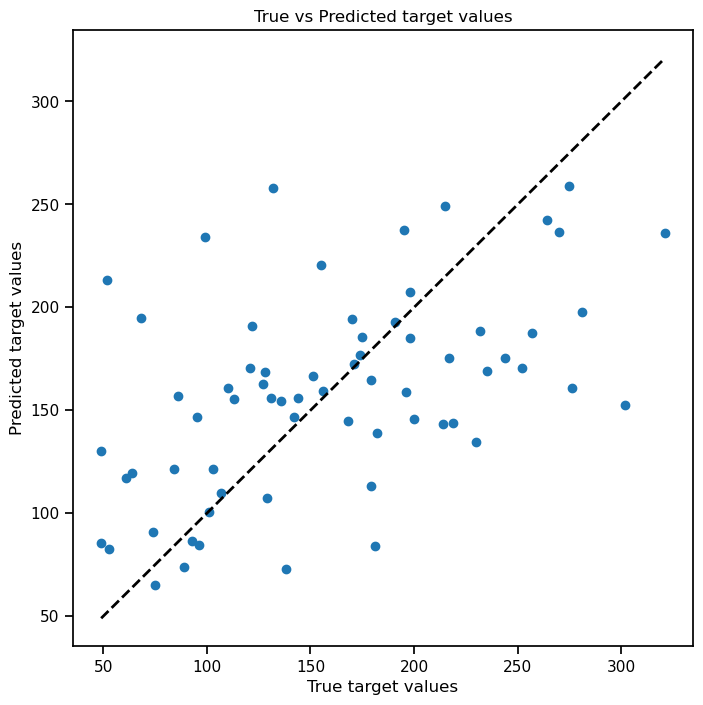

In [16]:
def plot_regression_predictions(y_true: np.ndarray, y_predicted: np.ndarray) -> None:
    plt.figure(figsize=(8, 8))
    sns.set_context("notebook")
    plt.scatter(y_true, y_predicted)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel("True target values")
    plt.ylabel("Predicted target values")
    plt.title("True vs Predicted target values")
    plt.show()

plot_regression_predictions(y_test, y_test_predicted)

Let's quantify this result. Common metrics for quantitative predictions are the mean absolute error (MAE), root mean squared error (RMSE) and the coefficient of determination (R2). The R2 score sets the error in relation to just predicting the mean of the data. A value of 0 is equal to always predicting the mean, a value of 1 means perfect correlation without any error.

\begin{align}
MAE &= \frac{1}{n} \sum_i^n | y_{true} - y_{pred} | \\
RMSE &= \sqrt{\frac{1}{n} \sum_i^n (y_{true} - y_{pred})^2} \\
R_2 &= 1- \frac{\sum_i (y_{true} - y_{pred})^2}{\sum_i (y_{true} - \bar{y})^2}
\end{align}

Calculate the MAE, RMSE and R_2 of the test set. Save them to the variables `mae_linear`, `rmse_linear`, and `r2_linear` using sklearn methods. They have to be below/above the expected typical values to pass the following test cell.

In [17]:
mae_linear: np.ndarray = mean_absolute_error(y_test, y_test_predicted)
rmse_linear: np.ndarray = mean_squared_error(y_test, y_test_predicted, squared=False)
r2_linear: np.ndarray = r2_score(y_test, y_test_predicted)

print(f"Mean Absolute Error: {mae_linear:.2f}")
print(f"Root Mean Squared Error: {rmse_linear:.2f}")
print(f"R^2 Score: {r2_linear:.2f}")


Mean Absolute Error: 47.17
Root Mean Squared Error: 60.66
R^2 Score: 0.23


In [18]:
# Test cell

assert mae_linear is not None, "mae_linear is None. You should calculate the Mean Absolute Error."
assert rmse_linear is not None, "rmse_linear is None. You should calculate the Root Mean Squared Error."
assert r2_linear is not None, "r2_linear is None. You should calculate the R^2 Score."

assert mae_linear < 100, "The Mean Absolute Error is too high"
assert rmse_linear < 100, "The Root Mean Squared Error is too high"
assert r2_linear > 0.0, "The R^2 Score is too low"
assert r2_linear < 1.0, "The R^2 Score is too high"

Another nice thing about linear regression is the ability to gauge the importance of a feature for the prediction. Have a look at the values of the weights. Which feature has the highest influence on the prediction? Save its name as given in the dataset explanation to the variable `most_important_feature` to pass the following test cell.

In [19]:
print(model.coef_)
most_impactful_feature: str = diabetes_feature_names[np.argmax(np.abs(model.coef_))]
print(f"The most impactful feature is {most_impactful_feature}")

[ -30.47 -256.73  544.38  307.35 -604.2   303.08  -11.02  133.67  723.68
   67.82]
The most impactful feature is s5


In [20]:
# Test cell

assert most_impactful_feature is not None, "most_impactful_feature is None. You should find the most impactful feature and save the feature name in the variable most_impactful_feature."

assert most_impactful_feature in diabetes_feature_names, "most_impactful_feature is not in diabetes_feature_names"
assert most_impactful_feature == diabetes_feature_names[np.argmax(np.abs(model.coef_))], "most_impactful_feature is not the feature with the highest absolute weight. Did you account for the absolute value of the weight?"

The results were rather measely, but at least better than simply guessing the mean. Let's move on to another example and see, of we can do better.

Linear polynomic regression works in principle rather similar to linear regression. We only have to include the higher monomials in the $\mathbf{x}$ and their weights in the $\mathbf{w}$ vectors.

\begin{equation*}
    f_w(x_0,x_1,...,x_n) = w_{b} 1 + w_{0,1} x_0^1 + w_{0,2} x_0^2 + w_{0,3} x_0^3 + ... + w_{1,1} x_1^1 + w_{1,2} x_1^2 + w_{1,3} x_1^3 + ... + w_{n,1} x_n^1 + w_{n,2} x_n^2 + w_{n,3} x_n^3 + ...
\end{equation*}

\begin{equation*}
\mathbf{x} =
\begin{pmatrix}
  1 \\ x_0^1 \\ x_0^2 \\ x_0^3 \\ \vdots \\ x_1^1 \\ x_1^2 \\ x_1^3 \\ \vdots \\ x_n^1 \\ x_n^2 \\ x_n^3 \\ \vdots \\
\end{pmatrix},
\mathbf{w} = 
\begin{pmatrix}
  w_b \\ w_{0,1} \\ w_{0,2} \\ w_{0,3} \\ \vdots \\ w_{1,1} \\ w_{1,2} \\ w_{1,3} \\ \vdots \\ w_{n,1} \\ w_{n,2} \\ w_{n,3} \\ \vdots  \\
\end{pmatrix}
\end{equation*}

The same way interactions between features such as $x_0 * x_1$ can also be included.

Use `X_train` to preprocess your data for a polynomial model up to the 10th degree with interactions and save the results to a variable called `X_train_polynomial`, initialize a new linear regression model called `model_polynomial`, train it with `X_train_polynomial` and `y_train`, and predict the test set `X_test_polynomial`(which you have to transform from `X_test` first) with it. Save the results to a variable `y_test_predicted_polynomial` to pass the following test cell.

In [21]:
polynomial_features: PolynomialFeatures = PolynomialFeatures(degree=10)
X_train_polynomial: np.ndarray = polynomial_features.fit_transform(X_train)
X_test_polynomial: np.ndarray = polynomial_features.transform(X_test)

model_polynomial: LinearRegression = LinearRegression()
model_polynomial.fit(X_train_polynomial, y_train)

y_test_predicted_polynomial: np.ndarray = model_polynomial.predict(X_test_polynomial)

In [22]:
# Test cell

degree: int = 10
n_polynomial_features_with_interaction: int = sum([scipy.special.comb(10+i-1, i) for i in range(degree+1)])

assert X_train_polynomial is not None, "X_train_polynomial is None. You should transform X_train using polynomial features."
assert X_test_polynomial is not None, "X_test_polynomial is None. You should transform X_test using polynomial features."
assert model_polynomial is not None, "model_polynomial is None. You should create a linear polynomial regression model."
assert y_test_predicted_polynomial is not None, "y_test_predicted_polynomial is None. You should predict the target values using the polynomial model."

assert X_train_polynomial.shape == (X_train.shape[0], n_polynomial_features_with_interaction), f"The shape of X_train_polynomial is incorrect, expected {(X_train.shape[0], n_polynomial_features_with_interaction)} but got {X_train_polynomial.shape}. Did you include interactions?"
assert X_test_polynomial.shape == (X_test.shape[0], n_polynomial_features_with_interaction), f"The shape of X_test_polynomial is incorrect, expected {(X_test.shape[0], n_polynomial_features_with_interaction)} but got {X_test_polynomial.shape}. Did you include interactions?"
assert isinstance(model_polynomial, sklearn.linear_model.LinearRegression), "model_polynomial is not an instance of LinearRegression"
assert hasattr(model_polynomial, 'coef_'), "model_polynomial was not trained yet"
assert hasattr(model_polynomial, 'intercept_'), "model_polynomial was not trained yet"
assert y_test_predicted_polynomial.shape == y_test.shape, "The shape of y_test_predicted_polynomial is incorrect, expected {y_test.shape} but got {y_test_predicted_polynomial.shape}"

Now proceed as you did with the linear model. Call the plot function and calculate the metrics. Save the metrics to  `mae_polynomial`, `rmse_polynomial`, and `r2_polynomial` to pass the following test cell.

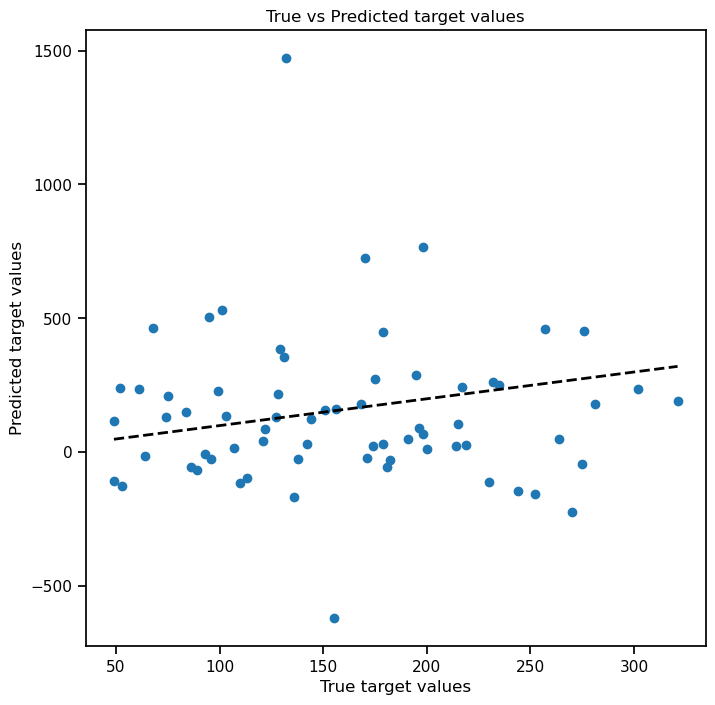

Mean Absolute Error: 200.90
Root Mean Squared Error: 286.94
R^2 Score: -16.22


In [23]:
plot_regression_predictions(y_test, y_test_predicted_polynomial)

mae_polynomial: np.ndarray = mean_absolute_error(y_test, y_test_predicted_polynomial)
rmse_polynomial: np.ndarray = mean_squared_error(y_test, y_test_predicted_polynomial, squared=False)
r2_polynomial: np.ndarray = r2_score(y_test, y_test_predicted_polynomial)

print(f"Mean Absolute Error: {mae_polynomial:.2f}")
print(f"Root Mean Squared Error: {rmse_polynomial:.2f}")
print(f"R^2 Score: {r2_polynomial:.2f}")

In [24]:
# Test cell

assert mae_polynomial is not None, "mae_polynomial is None. You should calculate the Mean Absolute Error."
assert rmse_polynomial is not None, "rmse_polynomial is None. You should calculate the Root Mean Squared Error."
assert r2_polynomial is not None, "r2_polynomial is None. You should calculate the R^2 Score."

assert mae_polynomial is not None, "mae_polynomial is None. You need to define it first"
assert rmse_polynomial is not None, "rmse_polynomial is None. You need to define it first"
assert r2_polynomial is not None, "r2_polynomial is None. You need to define it first"

Wupps, seems like we overfitted the data. The predictions are worse than just predicting the mean, as indicated by a negative R2 score. Let's see if we can tame the model using **regularization**. The Lasso regression penalizes coefficients with a linear factor $\alpha$ in the loss function

Initialize a new lasso regression model called `model_lasso` with a penalty factor of 0.5, train it with `X_train_polynomial` and `y_train`, and predict the test set `X_test_polynomial`. Save the results to a variable `y_test_predicted_lasso` to pass the following test cell.

In [25]:
model_lasso: Lasso = Lasso(alpha=0.5)

model_lasso.fit(X_train_polynomial, y_train)

y_test_predicted_lasso: np.ndarray = model_lasso.predict(X_test_polynomial)

In [26]:
# Test cell

alpha: float = 0.5

assert model_lasso is not None, "model_lasso is None. You should create a Lasso model."
assert y_test_predicted_lasso is not None, "y_test_predicted_lasso is None. You should predict the target values using the Lasso model."

assert isinstance(model_lasso, sklearn.linear_model.Lasso), "model_lasso is not an instance of Lasso"
assert model_lasso.alpha == alpha, f"model_lasso has an incorrect alpha value, expected {alpha} but got {model_lasso.alpha}"
assert hasattr(model_lasso, 'coef_'), "model_lasso was not trained yet"
assert hasattr(model_lasso, 'intercept_'), "model_lasso was not trained yet"
assert y_test_predicted_lasso.shape == y_test.shape, "The shape of y_test_predicted_lasso is incorrect, expected {y_test.shape} but got {y_test_predicted_lasso.shape}"

Evaluate the Lasso model with plot and metrics. Use the variables `mae_lasso`, `rmse_lasso` and `r2_lasso`.

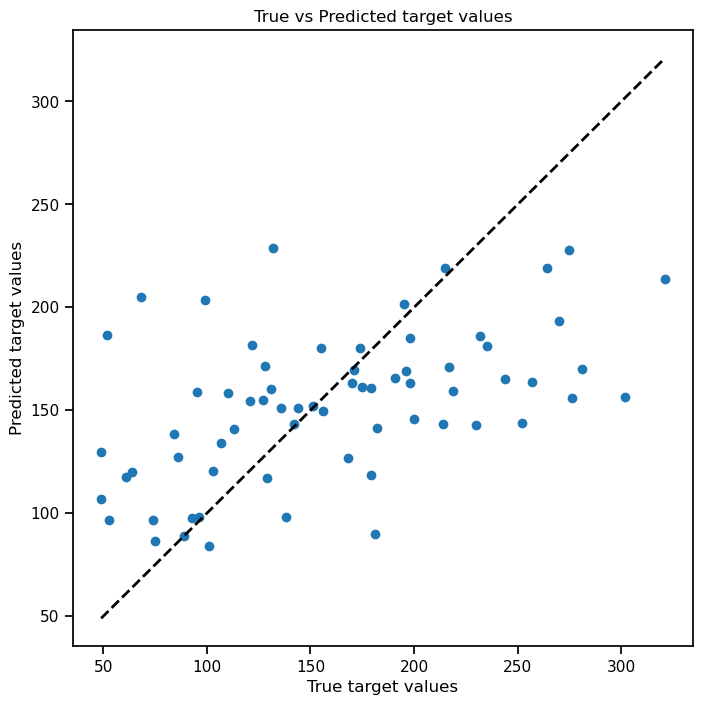

Mean Absolute Error: 47.01
Root Mean Squared Error: 60.01
R^2 Score: 0.25


In [27]:
plot_regression_predictions(y_test, y_test_predicted_lasso)

mae_lasso: np.ndarray = mean_absolute_error(y_test, y_test_predicted_lasso)
rmse_lasso: np.ndarray = mean_squared_error(y_test, y_test_predicted_lasso, squared=False)
r2_lasso: np.ndarray = r2_score(y_test, y_test_predicted_lasso)

print(f"Mean Absolute Error: {mae_lasso:.2f}")
print(f"Root Mean Squared Error: {rmse_lasso:.2f}")
print(f"R^2 Score: {r2_lasso:.2f}")

In [28]:
# Test cell

assert mae_lasso is not None, "mae_lasso is None. You should calculate the Mean Absolute Error."
assert rmse_lasso is not None, "rmse_lasso is None. You should calculate the Root Mean Squared Error."
assert r2_lasso is not None, "r2_lasso is None. You should calculate the R^2 Score."

assert mae_lasso is not None, "mae_lasso is None. You need to define it first"
assert rmse_lasso is not None, "rmse_lasso is None. You need to define it first"
assert r2_lasso is not None, "r2_lasso is None. You need to define it first"

In the end we couldn't find a much better regression model than the simple linear regression with the data we had. Maybe we were missing a crucial measurement for meaningful predictions. Maybe a non-linear transformation for the existing features would have lead to a more succesful model.

Feel free to explore the remaining regression models like Ridge or Elastic Net or experiment with other regularization values.

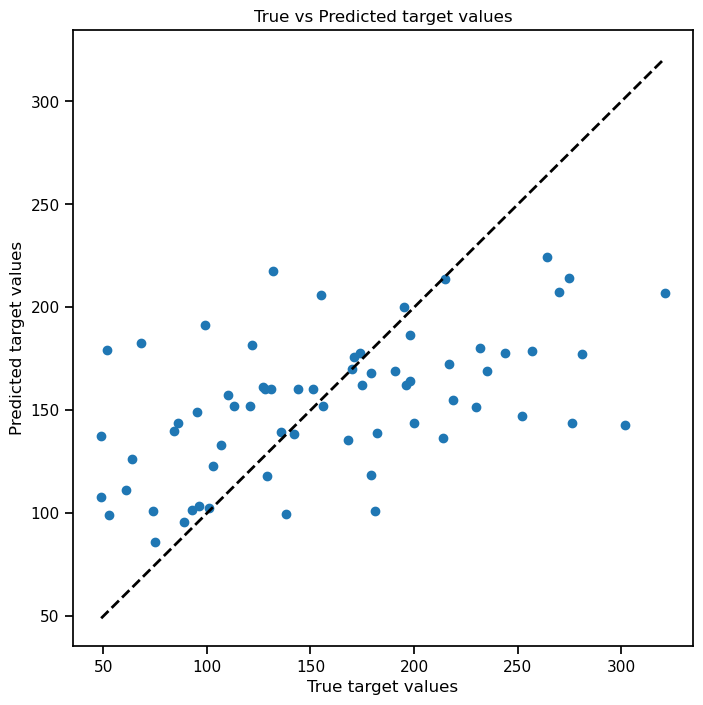

Mean Absolute Error: 46.67
Root Mean Squared Error: 59.13
R^2 Score: 0.27


In [29]:
model_ridge: Ridge = Ridge(alpha=0.75)
model_ridge.fit(X_train_polynomial, y_train)
y_test_predicted_ridge: np.ndarray = model_ridge.predict(X_test_polynomial)

plot_regression_predictions(y_test, y_test_predicted_ridge)
mae_ridge: np.ndarray = mean_absolute_error(y_test, y_test_predicted_ridge)
rmse_ridge: np.ndarray = mean_squared_error(y_test, y_test_predicted_ridge, squared=False)
r2_ridge: np.ndarray = r2_score(y_test, y_test_predicted_ridge)

print(f"Mean Absolute Error: {mae_ridge:.2f}")
print(f"Root Mean Squared Error: {rmse_ridge:.2f}")
print(f"R^2 Score: {r2_ridge:.2f}")

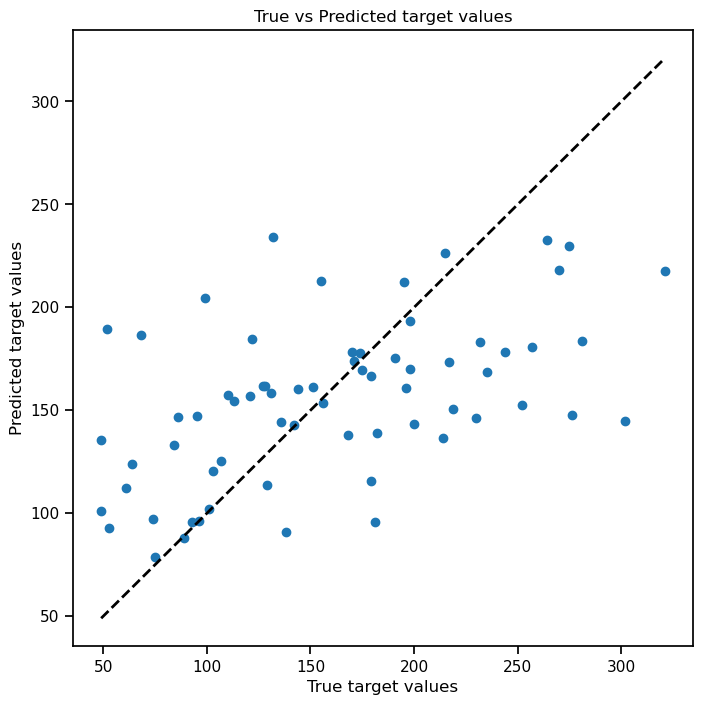

Mean Absolute Error: 46.16
Root Mean Squared Error: 59.20
R^2 Score: 0.27


In [30]:
model_elastic_net: ElasticNet = ElasticNet(alpha=0.001, l1_ratio=0.001)
model_elastic_net.fit(X_train_polynomial, y_train)
y_test_predicted_elastic_net: np.ndarray = model_elastic_net.predict(X_test_polynomial)

plot_regression_predictions(y_test, y_test_predicted_elastic_net)
mae_elastic_net: np.ndarray = mean_absolute_error(y_test, y_test_predicted_elastic_net)
rmse_elastic_net: np.ndarray = mean_squared_error(y_test, y_test_predicted_elastic_net, squared=False)
r2_elastic_net: np.ndarray = r2_score(y_test, y_test_predicted_elastic_net)

print(f"Mean Absolute Error: {mae_elastic_net:.2f}")
print(f"Root Mean Squared Error: {rmse_elastic_net:.2f}")
print(f"R^2 Score: {r2_elastic_net:.2f}")